In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/oracle/ahp.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

print(df.shape)
df.tail()

(1652, 1)


,Servers
Date,
2022-12-11,0
2022-12-12,105
2022-12-13,40
2022-12-14,26
2022-12-15,35


<Axes: xlabel='Date'>

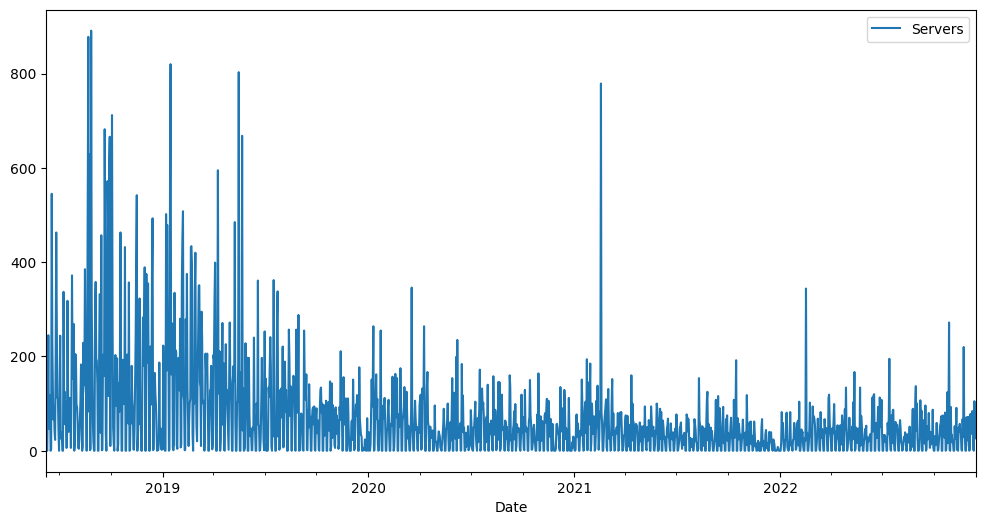

In [ ]:
df.plot(figsize=(12,6))

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

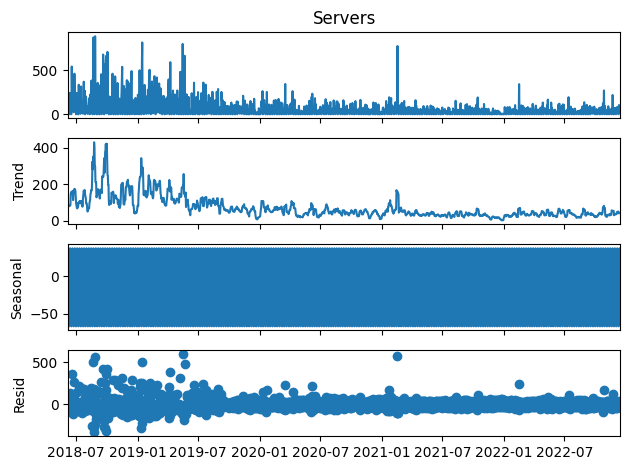

In [ ]:
results = seasonal_decompose(df['Servers'])
results.plot();

In [ ]:
#convert to stationary if predictions not accurate, shouldn't need to with RNN tho
len(df)

1652

In [ ]:
#348 days of 2022
train = df.iloc[:1622]
test = df.iloc[1622:]

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [ ]:
df.head(),df.tail()

(            Servers
 Date               
 2018-06-08       85
 2018-06-09        6
 2018-06-10        0
 2018-06-11      100
 2018-06-12      245,
             Servers
 Date               
 2022-12-11        0
 2022-12-12      105
 2022-12-13       40
 2022-12-14       26
 2022-12-15       35)

In [ ]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [ ]:
scaled_train[:10]

array([[0.09539843],
       [0.00673401],
       [0.        ],
       [0.11223345],
       [0.27497194],
       [0.05274972],
       [0.09090909],
       [0.13131313],
       [0.        ],
       [0.00448934]])

In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
# define generator
n_input = 30
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [ ]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.09539843 0.00673401 0.         0.11223345 0.27497194 0.05274972
 0.09090909 0.13131313 0.         0.00448934 0.61167228 0.2637486
 0.14702581 0.07407407 0.1043771  0.04601571 0.02581369 0.22558923
 0.51964085 0.2996633  0.12682379 0.12233446 0.04826038 0.
 0.15151515 0.27384961 0.0291807  0.04377104 0.03367003 0.        ]
Predict this y: 
 [[0.]]


In [ ]:
X.shape

(1, 30, 1)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [ ]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100)               40800     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# fit model
model.fit(generator,epochs=50)

Epoch 1/50
1592/1592 [==============================] - 42s 25ms/step - loss: 0.0118
Epoch 2/50
1592/1592 [==============================] - 43s 27ms/step - loss: 0.0114
Epoch 3/50
1592/1592 [==============================] - 39s 24ms/step - loss: 0.0112
Epoch 4/50
1592/1592 [==============================] - 40s 25ms/step - loss: 0.0112
Epoch 5/50
1592/1592 [==============================] - 38s 24ms/step - loss: 0.0111
Epoch 6/50
1592/1592 [==============================] - 38s 24ms/step - loss: 0.0111
Epoch 7/50
1592/1592 [==============================] - 39s 24ms/step - loss: 0.0109
Epoch 8/50
1592/1592 [==============================] - 43s 27ms/step - loss: 0.0110
Epoch 9/50
1592/1592 [==============================] - 40s 25ms/step - loss: 0.0109
Epoch 10/50
1592/1592 [==============================] - 37s 23ms/step - loss: 0.0108
Epoch 11/50
1592/1592 [==============================] - 43s 27ms/step - loss: 0.0108
Epoch 12/50
1592/1592 [==============================] - 32s 20

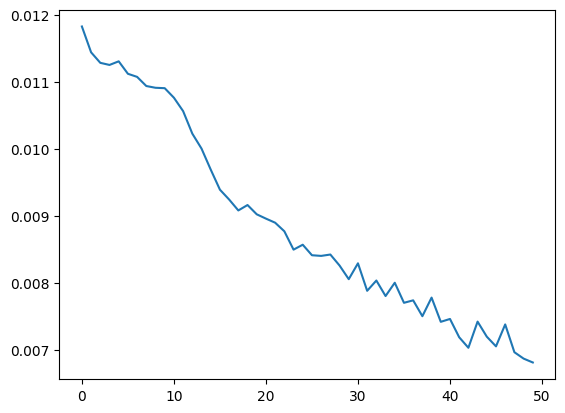

In [ ]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [ ]:
last_train_batch = scaled_train[-30:]

In [ ]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [ ]:
model.predict(last_train_batch)

1/1 [==============================] - 1s 669ms/step


array([[0.05556853]], dtype=float32)

In [ ]:
scaled_test[0]

array([0.00561167])

In [ ]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):

    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]

    # append the prediction into the array
    test_predictions.append(current_pred)

    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 24ms/step


In [ ]:
test_predictions

[array([0.05556853], dtype=float32),
 array([0.07943895], dtype=float32),
 array([0.06753089], dtype=float32),
 array([0.08122899], dtype=float32),
 array([0.07682288], dtype=float32),
 array([0.04952057], dtype=float32),
 array([0.02483705], dtype=float32),
 array([0.05566622], dtype=float32),
 array([0.06388585], dtype=float32),
 array([0.06405529], dtype=float32),
 array([0.07340756], dtype=float32),
 array([0.07075238], dtype=float32)]

In [ ]:
test.head()

,Servers
Date,
2022-12-04,5
2022-12-05,78
2022-12-06,46
2022-12-07,36
2022-12-08,84


In [ ]:
true_predictions = scaler.inverse_transform(test_predictions)

In [ ]:
test['Predictions'] = true_predictions

<ipython-input-61-920b79c3c314>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


<Axes: xlabel='Date'>

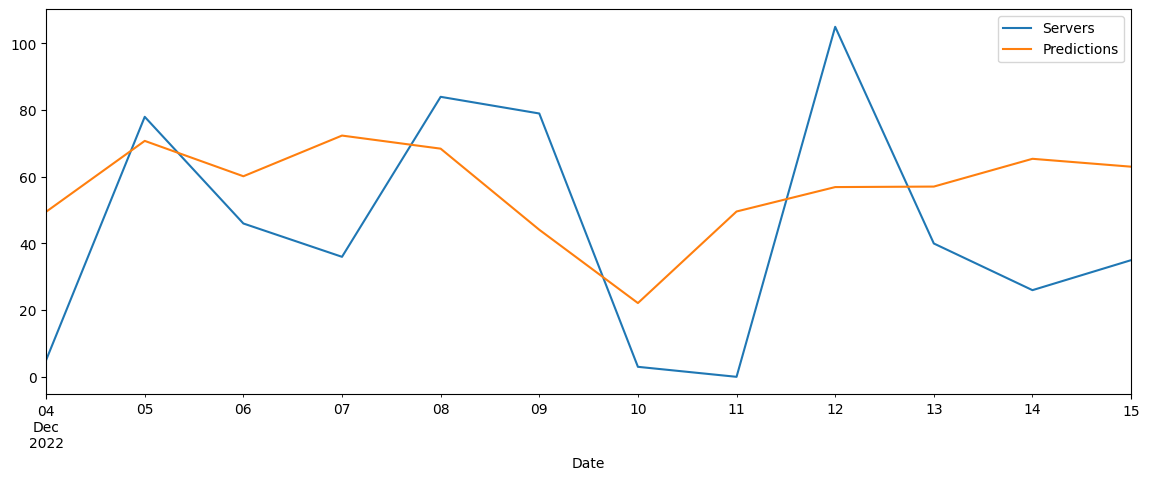

In [ ]:
test.plot(figsize=(14,5))

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['Servers'],test['Predictions']))
print(rmse)

32.63896462727022
